<a href="https://colab.research.google.com/github/TianYubo/genaibook/blob/main/13_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Appendix C. End-to-End Retrieval-Augmented Generation


This notebook is a supplementary material for the Appendix C of the [Hands-On Generative AI with Transformers and Diffusion Models book](https://learning.oreilly.com/library/view/hands-on-generative-ai/9781098149239/).

一个典型的 RAG 系统的组件包括：
1. Query：用户输入一个问题
2. Retriever：pipeline 从外部存储信息当中检索与问题最相似的信息（文档，上下文等）
3. pipeline 将问题和检索到的信息同时传递给 Model
4. Model 生成回答



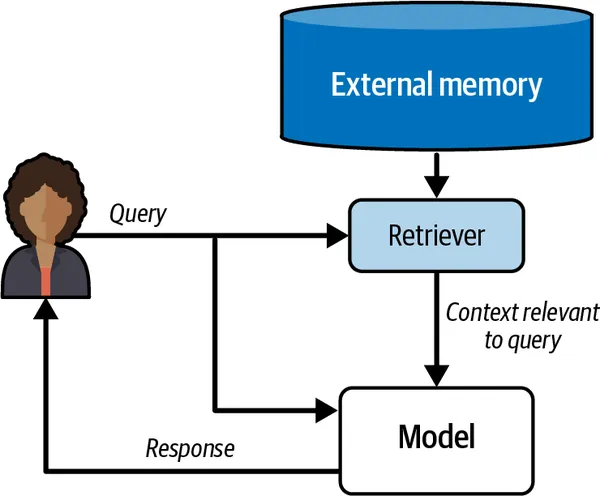

## 外部数据处理

与任何机器学习项目一样，第一步是加载数据并进行处理。我们将保持简单，专注于一个单一主题。想象一下，我们希望我们的模型生成与欧盟人工智能法案相关的内容，由于我们将使用的模型是在人工智能法案开始之前训练的，因此这不太可能包含在LLM的训练数据中。首先，我们将用下面的脚本加载一个实例文档。

这个文档是欧盟人工智能法案的 pdf 文档，可以直接下载


In [ ]:
import urllib.request

# Define the file name and URL
file_name = "The-AI-Act.pdf"
url = "https://artificialintelligenceact.eu/wp-content/uploads/2021/08/The-AI-Act.pdf"

# Download the file
urllib.request.urlretrieve(url, file_name)
print(f"{file_name} downloaded successfully.")

The-AI-Act.pdf downloaded successfully.


In [ ]:
!pip install langchain_community pypdf langchain-text-splitters

这里获取到的文档可能太长，无法一次性处理，因此我们将将其分成更小的块，并分别嵌入化每个块。每个块将是一个单独的文档，我们将将其与用户输入进行比较。

为了简单起见，我们可以使用来自 langchain 的一些预处理工具，这是一个提供创建 RAG 系统实用函数的库。例如，它有一个方便的 PyPDFLoader 类，可以从 PDF 中提取文本并处理分块。

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_name)
docs = loader.load()
print(len(docs))

108


PyPDFLoader 将 PDF 拆分为每页一个文档，在这种情况下产生了 108 个文档。我们将它们拆分成更小的块。langchain 库提供了帮助进行不同类型文本拆分的类。我们将使用 RecursiveCharacterTextSplitter ，它有两个关键参数：

`chunk_size`

每个块中的字符数。通常，将此与嵌入模型可以处理的最大token数相关联是个好主意，对于大多数句子转换器来说这个数字很小。否则，你可能会遇到文档部分被截断的风险。

`chunk_overlap`

每个块与上一个块重叠的字符数。这有助于避免在句子中间分割句子。我们将任意设置为 100 个字符（我们选择的块大小的五分之一）。

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500, chunk_overlap=100
)
chunks = text_splitter.split_documents(docs)
print(len(chunks))

851


这样得到的分块之后的文本如下：

In [ ]:
print(chunks[0].page_content)
print("----------------------------")
print(type(chunks))
print(type(chunks[0]))

EN   EN 
 
 
 
EUROPEAN 
COMMISSION  
Brussels, 21.4.2021  
COM(2021) 206 final 
2021/0106 (COD) 
 
Proposal for a 
REGULATION OF THE EUROPEAN PARLIAMENT AND OF THE COUNCIL 
LAYING DOWN HARMONISED RULES ON ARTIFICIAL INTELLIGENCE 
(ARTIFICIAL INTELLIGENCE ACT) AND AMENDING CERTAIN UNION 
LEGISLATIVE ACTS 
{SEC(2021) 167 final} - {SWD(2021) 84 final} - {SWD(2021) 85 final}
----------------------------
<class 'list'>
<class 'langchain_core.documents.base.Document'>


把文本块保存到列表中，并且打印出来，会得到下面的样子

In [ ]:
chunked_text = [chunk.page_content for chunk in chunks]
chunked_text[404]

'user or for own use on the Union market for its intended purpose; \n(12) ‘intended purpose’ means the use for which an AI system is intended by the provider, \nincluding the specific context and conditions of use,  as specified in the information \nsupplied by the provider in the instructions for use, promotional or sales materials \nand statements, as well as in the technical documentation; \n(13) ‘reasonably foreseeable misuse’ means the use of an AI system in a way that is not in'

### 将文本转化为 Embedding


现在我们有了文档（我们的块），我们需要创建它们的嵌入。我们将使用句子转换器模型作为检索器，它就像搜索引擎一样，用于找到与给定问题最相关的片段。

如何找到最相关的片段？这个过程依赖于计算用户查询的嵌入与我们的集合中文档的嵌入之间的**相似度**。

为了预计算所有文档的嵌入，我们将使用预训练的 SentenceTransformer 模型。以下的代码片段加载一个预训练的句子转换器模型，并使用它来把两个句子编码为 Embedding：

In [ ]:
from sentence_transformers import SentenceTransformer, util

sentences = ["I'm happy", "I'm full of happiness"]
model = SentenceTransformer("BAAI/bge-small-en-v1.5")

# Compute embedding for both sentences
embedding_1 = model.encode(sentences[0], convert_to_tensor=True)
embedding_2 = model.encode(sentences[1], convert_to_tensor=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


句子转换器返回整个句子的单个嵌入。尽管转换器模型通常为每个标记输出一个嵌入，但句子转换器经过训练，可以将标记嵌入汇总成一个句子嵌入，该嵌入能够捕捉整个文本的语义。

得到的 embedding 的值以及形状如下：

In [ ]:
print(embedding_1[:10])
print(embedding_2[:10])
print(f'Embedding_1 shape: {embedding_1.shape}')
print(f'Embedding_2 shape: {embedding_2.shape}')

tensor([-0.0562, -0.0264,  0.0629,  0.0064, -0.0116, -0.0082,  0.0940,  0.0294,
         0.0561,  0.0060], device='cuda:0')
tensor([-0.0332,  0.0113,  0.0429,  0.0370, -0.0322, -0.0026,  0.1363, -0.0192,
         0.0861,  0.0149], device='cuda:0')
Embedding_1 shape: torch.Size([384])
Embedding_2 shape: torch.Size([384])


根据**余弦相似度**比较两个 embedding 之间的相似度

In [ ]:
util.pytorch_cos_sim(embedding_1, embedding_2)

tensor([[0.8367]], device='cuda:0')

更简单的方法是这两个 embedding 的点积。下面是两种计算 tensor 点积的方法

In [ ]:
embedding_1 @ embedding_2

tensor(0.8367, device='cuda:0')

In [ ]:
import torch

torch.dot(embedding_1, embedding_2)

tensor(0.8367, device='cuda:0')

现在我们知道了如何嵌入一个句子，接下来让我们嵌入所有文档。
这为每个片段返回一个 384 维的嵌入向量。上面的文档在切分之后，会得到 851 个片段

In [ ]:
chunk_embeddings = model.encode(chunked_text, convert_to_tensor=True)
print(chunk_embeddings.shape)

torch.Size([851, 384])


## 检索

使用嵌入文档，我们可以检索与给定问题最相关的文档。我们将使用之前相同的方法来计算问题与每个文档之间的余弦相似度。幸运的是，相似度计算不需要迭代：可以通过使用内置的 PyTorch 矩阵乘法原语高效地执行。

In [ ]:
def search_documents(query, top_k=5):
    # Encode the query into a vector
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Calculate cosine similarity between the query and all document chunks
    similarities = util.pytorch_cos_sim(query_embedding, chunk_embeddings)

    # Get the top k most similar chunks
    top_k_indices = similarities[0].topk(top_k).indices

    # Retrieve the corresponding document chunks
    results = [chunked_text[i] for i in top_k_indices]

    return results

In [ ]:
search_documents("What are prohibited ai practices?", top_k=2)

['TITLE II \nPROHIBITED ARTIFICIAL INTELLIGENCE PRACTICES \nArticle 5 \n1. The following artificial intelligence practices shall be prohibited: \n(a) the placing on the market, putting into service or use of an A I system that \ndeploys subliminal techniques beyond a person’s consciousness in order to \nmaterially distort a person’s behaviour in a manner that causes or is likely to \ncause that person or another person physical or psychological harm;',
 'low or minimal risk. The list of prohibited practices in Title II comprises all those AI systems \nwhose use is considered unacceptable as contravening Unio n values, for instance by violating \nfundamental rights. The prohibitions covers practices that have a significant potential to \nmanipulate persons  through subliminal techniques beyond their consciousness or exploit']

可以看到通过 SentenceTransformer 计算出来的 embedding 使得我们能够正确地从输入问题中检索相关信息

## 生成回答

下一步是根据问题和检索到的文档生成响应。这里我们使用 `Qwen/Qwen2.5-0.5B-Instruct` 模型作为示例，我们可以随时尝试换一个模型

In [ ]:
from transformers import pipeline

generator = pipeline(
    "text-generation",
    model="Qwen/Qwen2.5-0.5B-Instruct",
    device='cuda'
)

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Device set to use cuda


我们将使用一个指令模型和聊天模板。*transformers* 库当中，有格式化提示以符合模型期望的实用工具。在 RAG 案例中，我们希望将检索到的文档添加到提示中：

In [ ]:
def generate_answer(query):
    # Retrieve relevant chunks
    context_chunks = search_documents(query, top_k=2)

    # Combine the chunks into a single context string
    context = "\n".join(context_chunks)

    # Generate a response using the context
    prompt = f"Context:\n{context}\n\nQuestion: {query}\nAnswer:"
    print(f'\nFormatted prompt sent to model: \n{prompt}')

    # Define the context to be passed to the model
    system_prompt = (
        "You are a friendly assistant that answers questions about the AI Act. "
        "If the user is not making a question, you can ask for clarification"
    )
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt},
    ]

    response = generator(messages, max_new_tokens=300)
    return response[0]["generated_text"][2]["content"]


def generate_answer_direct(query):
    # 直接使用查询生成答案，不进行文档搜索
    # 定义系统提示词
    system_prompt = (
        "You are a friendly assistant that answers questions about the AI Act. "
        "If the user is not making a question, you can ask for clarification"
    )

    # 构建消息列表
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": query},
    ]

    # 调用生成器获取回复
    response = generator(messages, max_new_tokens=300)
    return response[0]["generated_text"][2]["content"]


In [ ]:
answer = generate_answer("What are prohibited ai practices in the EU act?")
print(answer)


Formatted prompt sent to model: 
Context:
EUR: 
(a) non-compliance with the prohibition of the artificial intelligence practices 
referred to in Article 5; 
(b) non-compliance of the AI system with the requirements laid down in Article 
10. 
3. The non -compliance of the AI system with any requirements or obligations under 
this Regulation, other than those laid down in Articles 5 and 10, shall be subject to 
administrative fines of up to 250 000 EUR. 
4. Before taking decisions pursuant to this Article, the European Data Protection
TITLE II 
PROHIBITED ARTIFICIAL INTELLIGENCE PRACTICES 
Article 5 
1. The following artificial intelligence practices shall be prohibited: 
(a) the placing on the market, putting into service or use of an A I system that 
deploys subliminal techniques beyond a person’s consciousness in order to 
materially distort a person’s behaviour in a manner that causes or is likely to 
cause that person or another person physical or psychological harm;

Question: Wha

In [ ]:
answer = generate_answer_direct("What are prohibited ai practices in the EU act?")
print(answer)

The European Union (EU) has implemented several regulations and directives aimed at regulating artificial intelligence (AI) to ensure fair competition, privacy protection, and transparency. Some of these prohibitions include:

1. **Regulation on Artificial Intelligence (AI) Regulation 2018/649** - This regulation aims to protect consumers from deceptive advertising and ensure that companies have adequate information to make informed decisions.

2. **Prohibition on Discrimination in Employment** - It prohibits discrimination based on race, gender, sexual orientation, disability, age, or other protected characteristics.

3. **Regulation on Data Protection** - This regulation sets out requirements for data controllers and processors to ensure the security and protection of personal data, including the requirement to respect user rights such as access, correction, deletion, and erasure.

4. **Regulation on Privacy and Electronic Communications** - It provides rules for how companies handle

我们可以将基于 RAG 生成的回答与没有 RAG 的回答进行对比，从而判断模型是否有按照预期工作：

## 1. 有 RAG 的回答：

### **从外部数据当中获取到的上下文：**

```
欧元：  
(a) 不遵守第5条中关于人工智能实践的禁止规定；  
(b) 人工智能系统不符合第10条规定的要求。  

3. 人工智能系统未遵守本法规中除第5条和第10条以外的任何要求或义务的，将被处以最高250,000欧元的行政罚款。  

4. 在根据本条作出决定之前，欧洲数据保护...  

第二章  
被禁止的人工智能实践  

第5条
1. 下列人工智能实践应被禁止：  
(a) 投放市场、投入使用或使用任何超越个人意识、通过潜意识技术以实质性扭曲个人行为并导致或可能导致该人或其他人身体或心理伤害的人工智能系统；
```

### **人工输入的问题：**

> 欧盟法案中禁止的人工智能实践有哪些？


### **模型的回答：**

> 欧盟法案禁止以下人工智能实践：
1. 将人工智能系统投放市场。
2. 将其投入服务或使用。
3. 以扭曲个人行为的方式使用它。 具体而言，这些实践包括使用超出个人意识范围的潜意识技术，目的是实现有害后果。


## 2. 没有 RAG 得到的回答

### **人工输入的问题：**

> 欧盟法案中禁止的人工智能实践有哪些？

### **模型的回答：**

欧洲联盟（EU）已经实施了几项法规和指令，旨在规范人工智能（AI），以确保公平竞争、隐私保护和透明度。这些禁令包括：

1. **人工智能（AI）法规 2018/649** - 该法规旨在保护消费者免受欺骗性广告的影响，并确保公司拥有足够的信息做出明智决定。

2. **就业歧视禁令** - 禁止基于种族、性别、性取向、残疾、年龄或其他受保护特征的歧视。

3. **数据保护法规** - 该法规为数据控制者和处理者设定了要求，以确保个人数据的安全和保护，包括尊重用户的访问、更正、删除和擦除等权利。

4. **隐私和电子通信法规** - 提供了公司如何处理个人数据的规则，包括收集、处理、存储、共享和保护个人数据的要求。

5. **医疗保健中人工智能使用法规** - 要求医疗保健提供者负责任且合乎道德地使用人工智能，确保不会损害患者隐私或造成伤害。

6. **金融服务中的人工智能法规** - 规范金融机构，防止与其运营中使用的人工智能系统相关的欺诈活动。

这些法规旨在维护公众信任，并确保人工智能的使用方式有利于社会而非造成伤害。

可以看出来基于 RAG 的模型给出的回答更简短，更准确，更有针对性。这对于在某些专业领域上，给出足够准确的回答，而不是基于幻觉，毫无疑问是有帮助的。



---



# 生产级的 RAG

我们展示的代码是一个简单的 RAG 系统示例。在一个生产级系统中，你需要考虑几个额外的因素：

## 1. 分块

  真实数据的一个挑战是文档可能非常长。找到合适的块大小是一个设计决策，这取决于数据和模型：太小的片段会截断想法，而太大的片段则会稀释它们

## 2. 嵌入的大小

  大嵌入可能会占用大量内存。目前正在进行积极的研究，旨在在保持嵌入质量的同时减小嵌入的大小。对于嵌入进行量化也是目前热门的方向

## 3. 重新排序

  检索步骤在 RAG 系统中至关重要。我们的检索模型需要速度快，并且检索的准确性对于比较成千上万或数百万份文档来说是非常重要的，但它们并不必须要是最准确的。一旦检索到 top_k 文档，我们可以使用一个速度较慢但质量更高的模型重新排序它们。

## 4. 嵌入模型的评估

  现在已经有数十种句子转换模型。为了选择最适合您用例的最佳模型，我们建议查看 Massive Text Embedding Benchmark，该基准包含有关模型大小、嵌入维度以及数十个任务中的质量等信息。请注意，我们通常希望检索任务中的模型非常小且速度快，因此这应该是您决策的关键因素。